In [1]:
#from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from scipy import misc
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import matplotlib.image as mpimg
import tensorflow as tf
import matplotlib as mplib

%matplotlib inline

In [2]:
pickle_file = 'dataset_labels50by50.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (1140, 50, 50), (1140,))
('Validation set', (60, 50, 50), (60,))
('Test set', (300, 50, 50), (300,))


In [9]:
IMG_DIMS = [50, 50, 1]  #images are 200x200, RGB channel
KERNEL_SIZE = [5,5] #convolutional filter kernel size

def getParameters():
    # Network parameters (available at the command line)
    flags = tf.app.flags
    flags.DEFINE_integer('instance', 0, "Instance index")
    flags.DEFINE_integer('training_epochs', 5, "Number of training epochs")
    flags.DEFINE_float('learning_rate', 0.00025, "Learning rate")
    flags.DEFINE_integer('batch_size', 100, "batch size for learning")
    flags.DEFINE_integer('n_conv_1', 32, "number of filters at first convolutional hidden level")
    flags.DEFINE_integer('n_conv_2', 64, "number of filters at second convolutional hidden level")
    flags.DEFINE_integer('n_pool_1', 2, "size of pooling nodes at first pooling hidden level")
    flags.DEFINE_integer('n_pool_2', 2, "size of pooling nodes at second pooling hidden level")
    flags.DEFINE_integer('n_rec', 3000, "number of nodes at first reconstruction hidden level")
    flags.DEFINE_float('dropout', 0.4, "Dropout regularization probability")
    flags.DEFINE_string('log_dir', '/tmp/logs', "Directory to write log files in")
    return flags.FLAGS

In [4]:
def buildEncoder(x, isTraining, flags):
    """ 
    Builds the encoder network and returns outputs from the encoder layer
    """
    #input layer
    inputLayer = tf.reshape(x, [flags.batch_size, IMG_DIMS[0], IMG_DIMS[1], IMG_DIMS[2]])
    
    # Convolutional Layer #1
    # Computes FLAGS.n_conv_1 features using a 5x5 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 200, 200, 3]
    # Output Tensor Shape: [batch_size, 200, 200, FLAGS.n_conv_1]
    # For multi-channel images, use tf.contrib.layers.conv2d_in_plane
    conv1 = tf.layers.conv2d(
            inputs=inputLayer,
            filters=flags.n_conv_1,
            kernel_size=KERNEL_SIZE,
            padding="SAME",
            activation=tf.nn.relu,
            name='v1')

    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 200, 200, FLAGS.n_conv_1]
    # Output Tensor Shape: [batch_size, 100, 100, FLAGS.n_conv_1]
    pool1 = tf.layers.max_pooling2d(
            inputs=conv1,
            pool_size=flags.n_pool_1,
            strides=2)
    
    # Dropout layer
    #dropout = tf.layers.dropout(
     #       inputs = pool1, 
      #      rate = flags.dropout, 
       #     training = isTraining)
    
    # Convolutional Layer #2
    # Computes FLAGS.n_conv_2 features using a 5x5 filter.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 100, 100, FLAGS.n_conv_1]
    # Output Tensor Shape: [batch_size, 100, 100, FLAGS.n_conv_2]
    conv2 = tf.layers.conv2d(
            inputs=pool1,
            filters=flags.n_conv_2,
            kernel_size=KERNEL_SIZE,
            padding="SAME",
            activation=tf.nn.relu,
            name='v2')
    
    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 100, 100, 64]
    # Output Tensor Shape: [batch_size, 50, 50, 64]
    pool2 = tf.layers.max_pooling2d(
            inputs=conv2, 
            pool_size=flags.n_pool_2,
            strides=2)

    filter_summary_1 = tf.contrib.layers.summaries.summarize_weights(conv1)
    filter_summary_2 = tf.contrib.layers.summaries.summarize_weights(conv2)
    enc_summary = tf.summary.merge([filter_summary_1, filter_summary_2])

    #Flatten both convolutional layer features & merge as encoder output
    flat1 = tf.contrib.layers.flatten( pool1 )
    flat2 = tf.contrib.layers.flatten( pool2 )
    encOutput = tf.concat([flat1, flat2], 1)

    return (encOutput, enc_summary)

In [5]:
def buildDecoder(encodedInput, isTraining, flags, nOutputs):
    """ 
    Builds the decoder network and returns the output from the decoder layer
    """
    #Reconstruction layer #1, uses features from both pooled layers
    rec1 = tf.layers.dense(
            inputs = encodedInput,
            units = flags.n_rec,
            activation = tf.nn.relu)
    #Dropout regularization
    #dropout = tf.layers.dropout(
     #       inputs = rec1, 
      #      rate = flags.dropout, 
       #     training = isTraining)
    
    #Reconstruction layer #2
    rec2 = tf.layers.dense(
            inputs = rec1,
            units = nOutputs,
            activation = tf.nn.relu,
            name = 'output')
    
    return (rec2, "")

In [6]:
def buildGraph(flags):
    """
    Bulds the graph
    """
    N_CATS = 12
    N_INPUT = 50*50*1
    # tf Graph input (only pictures)
    x = tf.placeholder("float", [None, 50*50*1], name="input")
    isTraining = tf.placeholder("bool", [], name="is_training");
    
    # ENCODING LAYERS
    enc, enc_summary = buildEncoder(x, isTraining, flags)
    out, dec_summary = buildDecoder(enc, isTraining, flags, N_INPUT)

    # Learning criteria
    cost = tf.reduce_mean(tf.pow(x - out, 2))
    optimizer = tf.train.RMSPropOptimizer(flags.learning_rate).minimize(cost)

    graphSummary = tf.summary.merge([enc_summary, dec_summary])
    graph = {'input': x, 
             'output': out, 
             'cost': cost, 
             'optimizer': optimizer}
    return (graph, graphSummary)

In [7]:
def trainAutoencoder(tfSession, dataset, graph, summary, flags, saver, testset):
    """
    Trains a built graph. The variables should be previously initialized
    """
    # Define loss and optimizer, minimize the squared error
    x = graph['input']
    cost = graph['cost']
    optimizer = graph['optimizer']
    # Init logger
    costSummary = tf.summary.scalar('cost', cost)
    summarizer = tf.summary.FileWriter(flags.log_dir, graph=tfSession.graph)
    
    # Training cycle
    isTraining = tfSession.graph.get_tensor_by_name("is_training:0")
    
    dataset = np.reshape(dataset, [dataset.shape[0], -1])
    nBatches = int(dataset.shape[0]/flags.batch_size)
    c = np.inf
    
    for epoch in range(1, 1+flags.training_epochs):
        # Loop over all batches
        start = 0
        end = flags.batch_size
        np.random.shuffle(dataset)
        for i in range(nBatches):
            step = (epoch - 1) * nBatches + i
            # get next batch of images. 
            # since we're minimizing reconstruction errors, labels are ignored
            xBatch = dataset[start:end,:]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, costSummaryStr, summaryStr, c = tfSession.run(
                    [optimizer, costSummary, summary, cost], 
                    feed_dict={x: xBatch, isTraining: True})
            summarizer.add_summary(costSummaryStr, global_step=step)
            savepath = saver.save(tfSession, 'model1_final6')
            start = start + flags.batch_size
            end = end + flags.batch_size
            print "Epoch: {0:3d}, step = {1:3d} cost = {2:.6f} variables saved to {3}".format(epoch, step, c, savepath )
            
        # Display logs per epoch step
        print "Epoch: {0:3d}, cost = {1:.6f}".format(epoch, c)
        #testModel(tfSession, testset, graph, flags)
        if (0 == (epoch % 5)):
            summarizer.add_summary(summaryStr, global_step=step)
    summarizer.close()
    return c

In [8]:
def testModel(tfSession, dataset, graph, flags, nImgs=10):
    """
    Tests the models by passing images & displaying reconstructions
    """
    # Applying encoder and decoder over test set
    x = graph['input']
    isTraining = tfSession.graph.get_tensor_by_name('is_training:0')
    v1filters = tfSession.graph.get_collection('trainable_variables', 'v1')[0]
    v2filters = tfSession.graph.get_collection('trainable_variables', 'v2')[0]
    
    dataset = np.reshape(dataset, [dataset.shape[0],-1])
    output, v1imgs, v2imgs = tfSession.run(
            [graph['output'], v1filters, v2filters], 
            feed_dict={x: dataset[:flags.batch_size,:], isTraining: False})
    # Compare original images with their reconstructions
    dataset = np.reshape(dataset, [dataset.shape[0],IMG_DIMS[0], IMG_DIMS[1]])
    output = np.reshape(output, [output.shape[0], IMG_DIMS[0], IMG_DIMS[1]])
    f, a = mplib.pyplot.subplots(2, nImgs, figsize=(nImgs, 2))
    for i in range(nImgs):
        a[0][i].imshow(dataset[i,:,:])
        a[1][i].imshow(output[i,:,:])
    f.show()
    
    #Figure out how to 'name' the convolutional layers and get their variables
    #v1imgs = v1filters.eval(tfSession)
    #v2imgs = v2filters.eval(tfSession)
    
    fV1, aV1 = mplib.pyplot.subplots(8, flags.n_conv_1/8)
    assert( v1imgs.shape[-1] == flags.n_conv_1 )
    for i in range(flags.n_conv_1):
        aV1[i%8][i/8].imshow(v1imgs[:,:,0,i], cmap='gray')
#        aV1[i%8][i/8].imshow(v1imgs[:,:,0,i], cmap='gray', interpolation='nearest')
    fV1.show()
    
    fV2, aV2 = mplib.pyplot.subplots(8, 8)
    for i in range(64):
        aV2[i%8][i/8].imshow(v2imgs[:,:,0,i], cmap='gray')
    fV2.show()

/Users/raghu/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Major Epoch 1:
Epoch:   1, step =   0 cost = 0.007279 variables saved to model1_final6
Epoch:   1, step =   1 cost = 0.007482 variables saved to model1_final6
Epoch:   1, step =   2 cost = 0.007139 variables saved to model1_final6
Epoch:   1, step =   3 cost = 0.008033 variables saved to model1_final6
Epoch:   1, step =   4 cost = 0.008529 variables saved to model1_final6
Epoch:   1, step =   5 cost = 0.008185 variables saved to model1_final6
Epoch:   1, step =   6 cost = 0.008370 variables saved to model1_final6
Epoch:   1, step =   7 cost = 0.007655 variables saved to model1_final6
Epoch:   1, step =   8 cost = 0.007257 variables saved to model1_final6
Epoch:   1, step =   9 cost = 0.007645 variables saved to model1_final6
Epoch:   1, step =  10 cost = 0.008306 variables saved to model1_final6
Epoch:   1, cost = 0.008306
Epoch:   2, step =  11 cost = 0.008280 variables saved to model1_final6
Epoch:   2, step =  12 cost = 0.007549 variables saved to model1_final6
Epoch:   2, step =  1

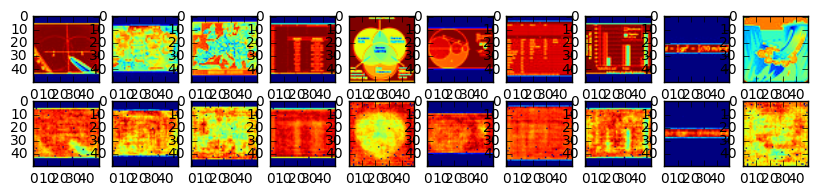

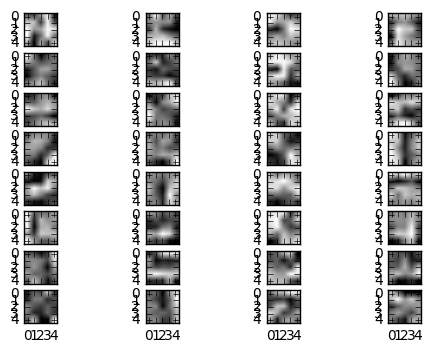

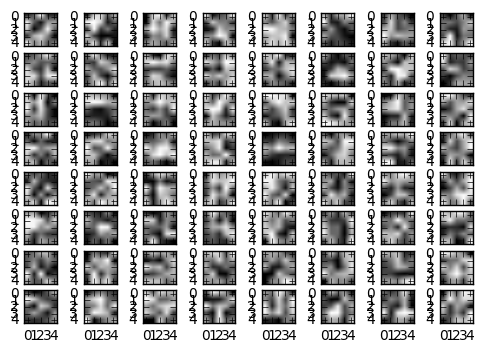

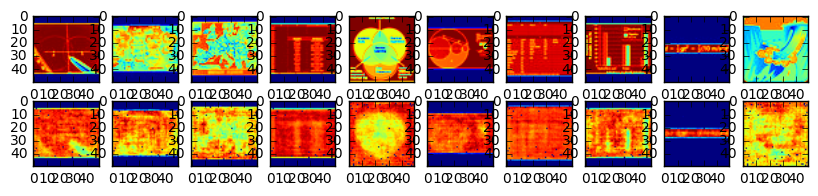

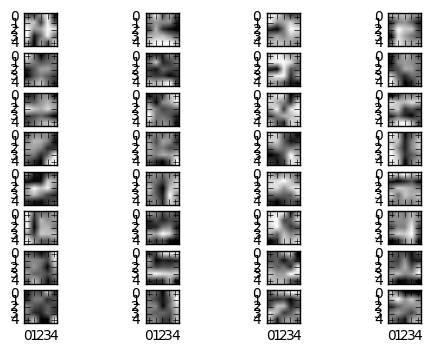

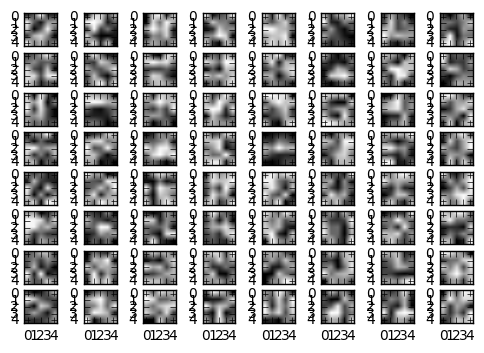

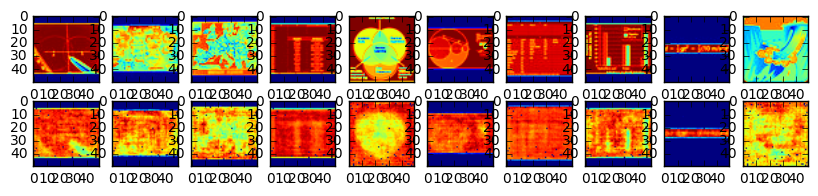

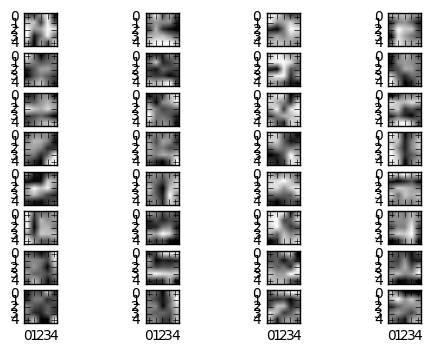

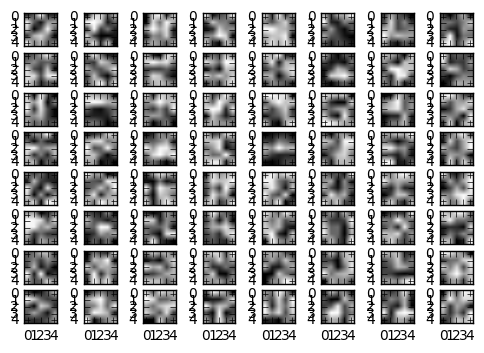

In [10]:

flags = getParameters()


#Build graph
graph, summary = buildGraph(flags)

# To save and restore variables incase of a crash
saver = tf.train.Saver(max_to_keep = 1)
#start an interactive session
sess = tf.InteractiveSession()

# Initialize the variables
#sess.run(tf.global_variables_initializer())
saver.restore(sess, '/Users/raghu/DeepCat/model1_final6')

testModel(sess, test_dataset, graph, flags)
cost = -1
for majorEpoch in range(1):
    print 'Major Epoch {0}:'.format(majorEpoch+1)
    #Train model    
    cost = trainAutoencoder(sess, train_dataset, graph, summary, flags, saver, test_dataset)
    #Test model
    testModel(sess, test_dataset, graph, flags)
    
print 'Optimization Finished!'
testModel(sess, test_dataset, graph, flags)
#saver = tf.train.Saver({"filter1": sess.graph.get_collection('trainable_variables', 'v1')[0], 
   #                    "filter2": sess.graph.get_collection('trainable_variables', 'v2')[0]})
#print os.path
#savepath = os.path.join(".", "model1_featurelearning")
#modelPath = saver.save(sess, savepath)
#print 'Model saved to {0}.'.format(modelPath)

In [11]:
savepath

[]

In [11]:
saver2 = tf.train.Saver({"v1": sess.graph.get_collection('trainable_variables', 'v1')[0], 
                     "v2": sess.graph.get_collection('trainable_variables', 'v2')[0]})
saver2.save(sess, 'model1_autoenc')

'model1_autoenc'